In [19]:
from datetime import datetime
from datetime import timedelta

import pandas
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.metrics import brier_score_loss
# from sklearn.calibration import calibration_curve

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

In [2]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release", "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["month"]
del df["day"]
del df["year"]
del df["post_month"]
df

,days_since_previous_release,release_post,date
id,,,
50,NaN,False,2016-02-15
123,NaN,False,2016-02-15
173,NaN,False,2016-02-15
156,NaN,False,2016-02-15
133,NaN,False,2016-02-15
...,...,...,...
280,16.0,True,2021-03-20
281,5.0,True,2021-03-25
282,7.0,True,2021-04-01


In [3]:
df.query("release_post == True & days_since_previous_release.isnull()")

,days_since_previous_release,release_post,date
id,,,


In [4]:
df = df[df["days_since_previous_release"].notnull()].copy()

In [5]:
filled_in = [dict(df.iloc[0])]
# df should already be sorted by date
current_date = filled_in[0]["date"]
days_since_release = filled_in[0]["days_since_previous_release"] # should be 0
while current_date < df.iloc[-1]["date"]:
    days_since_release += 1
    current_date = current_date + timedelta(days=1)
    in_df = df[df["date"] == current_date]
    if len(in_df) == 1:
        filled_in.append({"date" : current_date, "release_post" : in_df.iloc[0]["release_post"],
                          "days_since_previous_release" : days_since_release})
        days_since_release = 0
    else:
        filled_in.append({"date" : current_date, "release_post" : False,
                          "days_since_previous_release" : days_since_release})
        
features_df = pandas.DataFrame(filled_in)
features_df

,days_since_previous_release,release_post,date
0,0.0,True,2017-02-17
1,1.0,False,2017-02-18
2,2.0,False,2017-02-19
3,3.0,False,2017-02-20
4,4.0,False,2017-02-21
...,...,...,...
1515,5.0,False,2021-04-12
1516,6.0,False,2021-04-13
1517,7.0,False,2021-04-14
1518,8.0,False,2021-04-15


In [6]:
features_df["release_post"].value_counts()

False    1326
True      194
Name: release_post, dtype: int64

In [7]:
features_df["weekday"] = features_df["date"].apply(lambda x : x.weekday())
features_df["month"] = features_df["date"].apply(lambda x : x.month)
features_df

,days_since_previous_release,release_post,date,weekday,month
0,0.0,True,2017-02-17,4,2
1,1.0,False,2017-02-18,5,2
2,2.0,False,2017-02-19,6,2
3,3.0,False,2017-02-20,0,2
4,4.0,False,2017-02-21,1,2
...,...,...,...,...,...
1515,5.0,False,2021-04-12,0,4
1516,6.0,False,2021-04-13,1,4
1517,7.0,False,2021-04-14,2,4
1518,8.0,False,2021-04-15,3,4


---

In [8]:
false_df = features_df[features_df["release_post"] == False].sample(
    n=len(features_df[features_df["release_post"] == True]), random_state=1024)
len(false_df)

194

In [9]:
all_df = false_df.append(features_df[features_df["release_post"] == True], ignore_index=True)

In [10]:
train_df = all_df.sample(n=int(len(all_df) * 0.80), random_state=1024)
test_df = all_df[~all_df.index.isin(train_df.index)]
print(len(train_df), len(test_df))

310 78


---

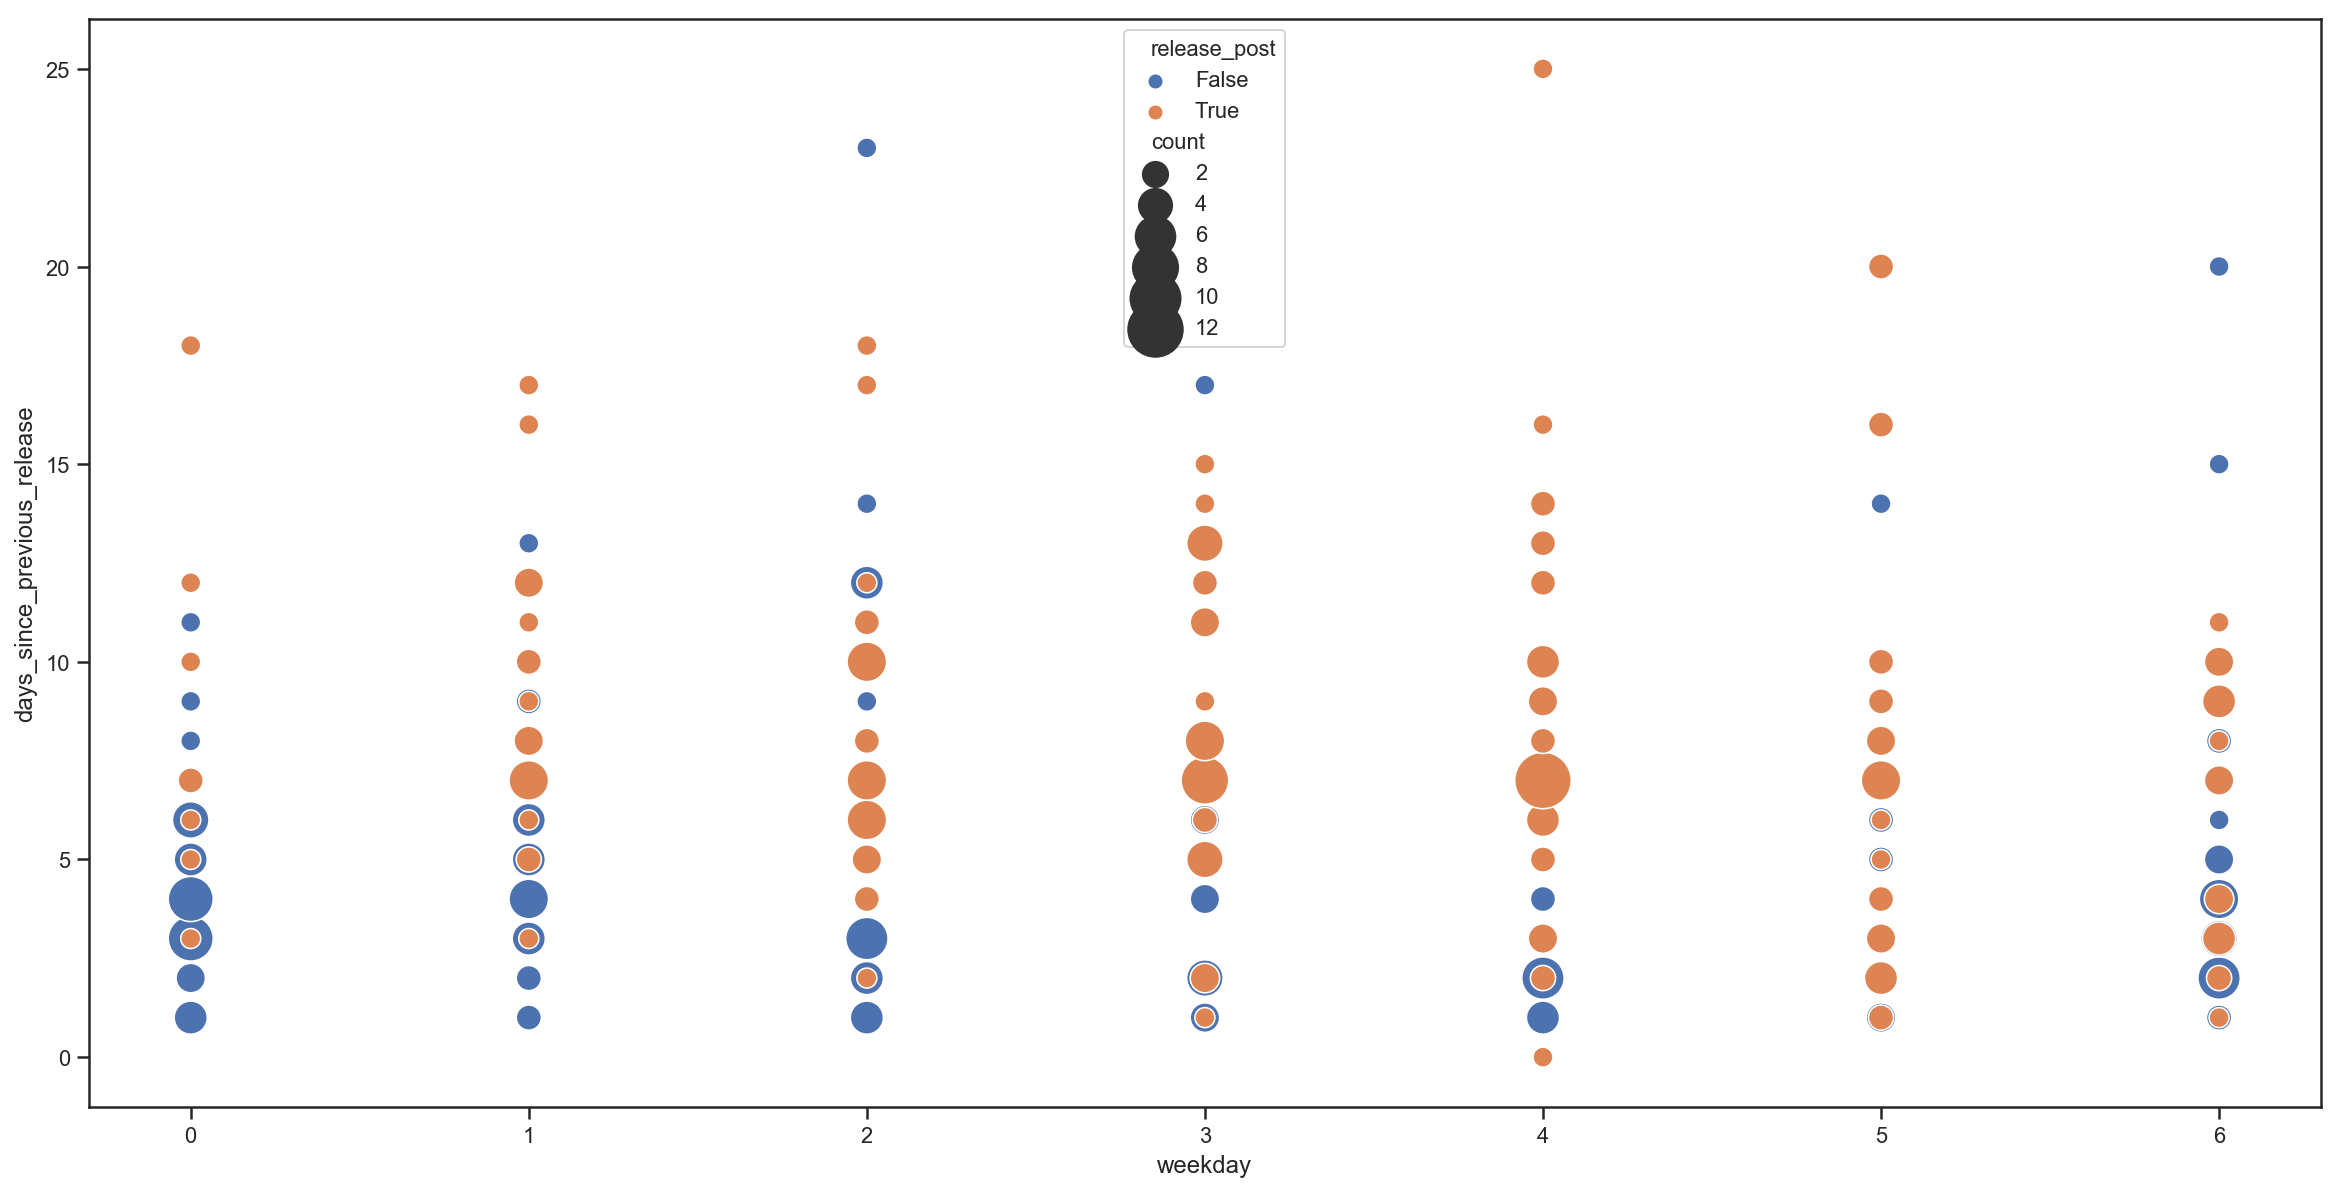

In [20]:
temp = all_df.groupby(["release_post", "weekday", "days_since_previous_release"]).size().reset_index()
temp = temp.rename(columns={0 : "count"})
sns.scatterplot(data=temp, x="weekday", y="days_since_previous_release", hue="release_post",
                size="count", sizes=(100, 800))

---

In [12]:
def get_f1(c):
    classifier = LogisticRegression(random_state=1024, solver="liblinear", C=c)
    classifier.fit(train_df[["days_since_previous_release", "weekday"]], train_df["release_post"])
    test_labels = classifier.predict(test_df[["days_since_previous_release", "weekday"]])
    
    true_pos = 0
    false_pos = 0
    false_neg = 0
    same = 0 # for accuracy
    for (gold, predicted) in zip(list(test_df["release_post"]), test_labels):
        if gold == predicted:
            same += 1
            if gold == True:
                true_pos += 1
        elif gold == True and predicted == False:
            false_neg += 1
        elif gold == False and predicted == True:
            false_pos += 1
            
    # accuracy = same / len(test_df)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    
    return 2 * ((precision * recall) / (precision + recall))

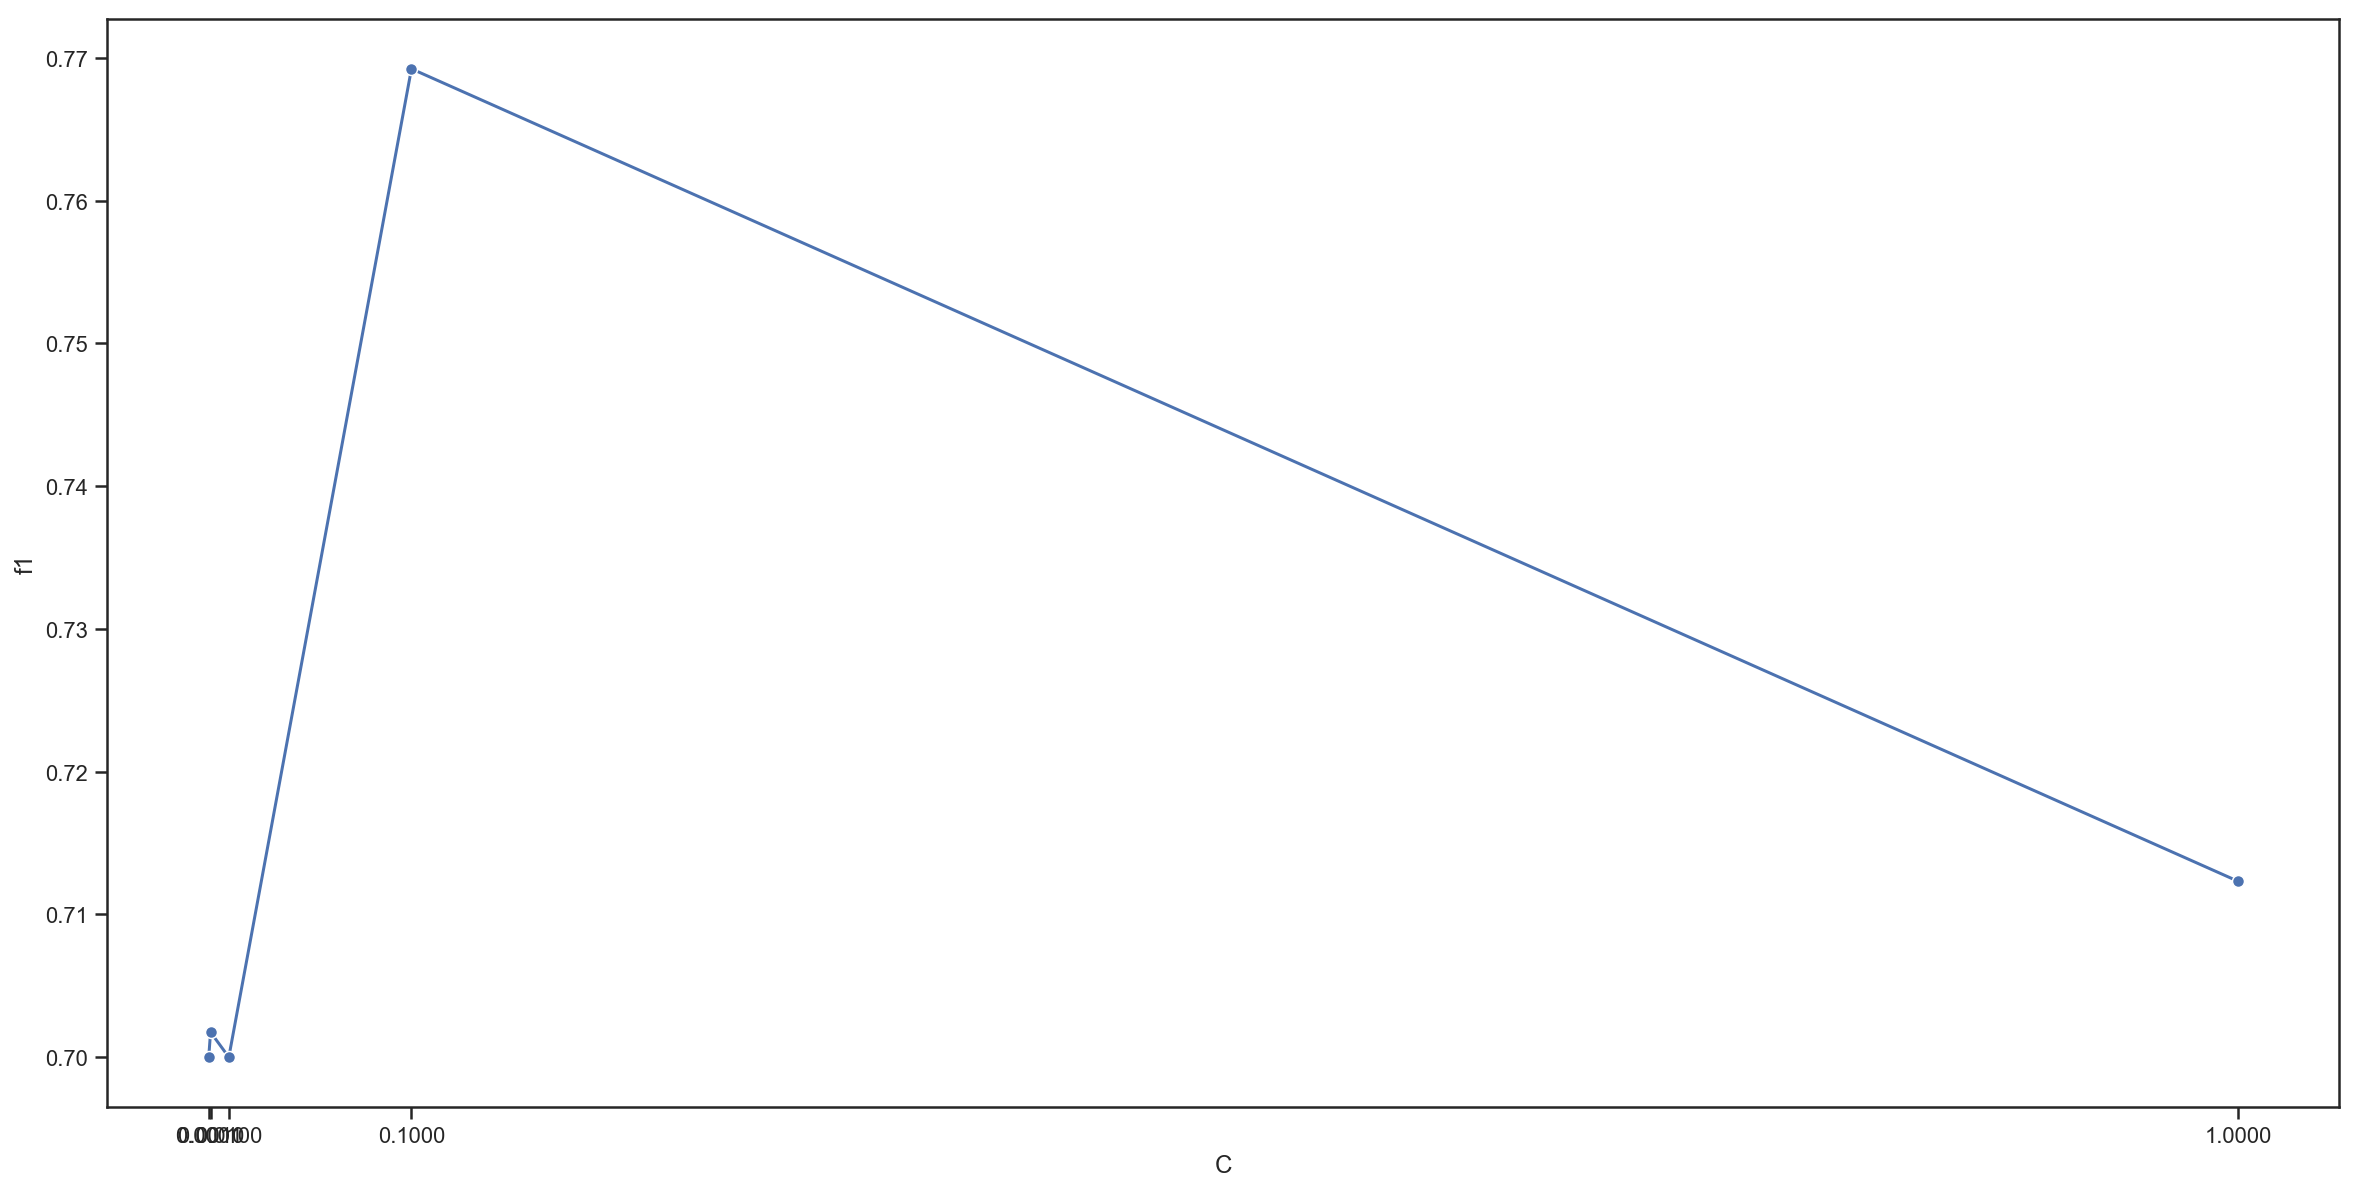

In [21]:
c_candidates = [0.0001, 0.001, 0.01, 0.1, 1]
f1s = []

for c in c_candidates:
    f1s.append(get_f1(c))
    
ax = sns.lineplot(x=c_candidates, y=f1s, marker="o")
ax.set(xlabel="C", ylabel="f1")
ax.set_xticks(c_candidates)
plt.show()

In [14]:
best_c_index = f1s.index(max(f1s))
print(c_candidates[best_c_index])
print(f1s[best_c_index])

0.1
0.7692307692307692


In [15]:
# # adapted from: https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html

# fig = plt.figure(figsize=(10, 10))
# ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

# ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
# y_pred = classifier.predict(test_df[["days_since_previous_release", "weekday"]])
# prob_pos = classifier.predict_proba(test_df[["days_since_previous_release", "weekday"]])[:, 1]

# clf_score = brier_score_loss(test_df["release_post"], prob_pos, pos_label=1)
# print("\tBrier: %1.3f" % (clf_score))

# fraction_of_positives, mean_predicted_value = calibration_curve(test_df["release_post"], prob_pos, n_bins=15)

# ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Brier = %1.3f" % (clf_score))

# ax1.set_ylabel("Fraction of positives")
# ax1.set_ylim([-0.05, 1.05])
# ax1.legend(loc="lower right")
# ax1.set_title('Calibration plots  (reliability curve)')

# plt.tight_layout()

---

In [16]:
classifier = LogisticRegression(random_state=1024, solver="liblinear", C=c_candidates[best_c_index])
classifier.fit(train_df[["days_since_previous_release", "weekday"]], train_df["release_post"])

LogisticRegression(C=0.1, random_state=1024, solver='liblinear')

In [17]:
days_since_most_recent_release = (datetime.now() - df.iloc[-1]["date"]).days

In [18]:
next_30_days = [(datetime.now() + timedelta(days=i), i + days_since_most_recent_release, 
                 (datetime.now() + timedelta(days=i)).weekday()) for i in range(1, 31)]
future_df = pandas.DataFrame(next_30_days, columns=["date", "days_since_previous_release", "weekday"])
future_df["predicted_release"] = classifier.predict([f[1:] for f in next_30_days])
future_df["release_probability"] = [x[1] for x in classifier.predict_proba([f[1:] for f in next_30_days])]

future_df

,date,days_since_previous_release,weekday,predicted_release,release_probability
0,2021-04-19 16:30:13.840405,3,0,False,0.381045
1,2021-04-20 16:30:13.840439,4,1,False,0.422041
2,2021-04-21 16:30:13.840445,5,2,False,0.464139
3,2021-04-22 16:30:13.840451,6,3,True,0.506755
4,2021-04-23 16:30:13.840456,7,4,True,0.549273
5,2021-04-24 16:30:13.840462,8,5,True,0.591084
6,2021-04-25 16:30:13.840468,9,6,True,0.631617
7,2021-04-26 16:30:13.840474,10,0,True,0.601596
8,2021-04-27 16:30:13.840479,11,1,True,0.641719
9,2021-04-28 16:30:13.840485,12,2,True,0.679950
